# Rate calculations

In [1]:
# In this section the code calculates the cumulative rates and shell rates of nearby CCSN

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import statistics as st
import warnings
warnings.filterwarnings("ignore")

data_path='Supernova sample with absolutes.csv'
lower = 'gehrels lowers.PNG.csv'
upper = 'gehrels uppers.PNG.csv'
years = 7
yearss= 8

In [2]:
def get_data_csv(data_path):
    df = pd.read_csv(data_path)
    return df

In [3]:
def get_limits(sn_list, limit_coefficients,a):
    new_list = []
    for i in range(len(sn_list)):
        value = sn_list[i]
        new_value = float(get_coef(value, limit_coefficients,a))
        new_list.append(new_value)
    return(new_list)

In [4]:
def get_coef(value, limit_coefficients,a):
    if value == 0:
        return 0
    if a ==-1:
        if value > 50:
            return(value-math.sqrt(value))
        else:
            return(limit_coefficients.loc[limit_coefficients['n']==value]['0.8413'])
    if a ==1:
        if value > 50:
            return(value+math.sqrt(value))
        else:
            return(limit_coefficients.loc[limit_coefficients['n']==value]['0.8413'])

In [5]:
def calculate_snr(sne, shells, years, distancebin,up_error_path,low_error_path, dist):
    upper_limits_shells = get_limits(shells, pd.read_csv(up_error_path),1)
    lower_limits_shells = get_limits(shells, pd.read_csv(low_error_path),-1)  
    upper_limits = get_limits(sne, pd.read_csv(up_error_path),1)
    lower_limits = get_limits(sne, pd.read_csv(low_error_path),-1)  
    distance = np.arange(1,31+distancebin, distancebin, dtype=int)
    sn_rate=np.array(0)
    sn_rate_up=np.array(0)
    sn_rate_low=np.array(0)
    shells_rate=[]
    shells_rate_low=[]
    shells_rate_up=[]
    shell_volumes=[4/3*math.pi*5**3,4/3*math.pi*10**3-4/3*math.pi*5**3, 4/3*math.pi*15**3-4/3*math.pi*10**3, 4/3*math.pi*20**3-4/3*math.pi*15**3, 4/3*math.pi*25**3-4/3*math.pi*20**3, 4/3*math.pi*30**3-4/3*math.pi*25**3]
    if len(shells) != 15:
        for i in range(len(shells)):
            shells_rate_up.append((upper_limits_shells[i]/(years*shell_volumes[i]*10**(-4)))-(shells[i]/(years*shell_volumes[i]*10**(-4))))
            shells_rate_low.append((shells[i]/(years*shell_volumes[i]*10**(-4)))-(lower_limits_shells[i]/(years*shell_volumes[i]*10**(-4))))
            shells_rate.append(shells[i]/(years*shell_volumes[i]*10**(-4)))    
    if len(shells) == 15:
        shell_volumes=[4/3*math.pi*2**3,4/3*math.pi*4**3-4/3*math.pi*2**3, 4/3*math.pi*6**3-4/3*math.pi*4**3, 4/3*math.pi*8**3-4/3*math.pi*6**3, 4/3*math.pi*10**3-4/3*math.pi*8**3, 4/3*math.pi*12**3-4/3*math.pi*10**3, 4/3*math.pi*14**3-4/3*math.pi*12**3, 4/3*math.pi*16**3-4/3*math.pi*14**3, 4/3*math.pi*18**3-4/3*math.pi*16**3, 4/3*math.pi*20**3-4/3*math.pi*18**3, 4/3*math.pi*22**3-4/3*math.pi*20**3, 4/3*math.pi*24**3-4/3*math.pi*22**3, 4/3*math.pi*26**3-4/3*math.pi*24**3, 4/3*math.pi*28**3-4/3*math.pi*26**3, 4/3*math.pi*30**3-4/3*math.pi*28**3]
        for i in range(len(shells)):
            shells_rate_up.append((upper_limits_shells[i]/(years*shell_volumes[i]*10**(-4)))-(shells[i]/(years*shell_volumes[i]*10**(-4))))
            shells_rate_low.append((shells[i]/(years*shell_volumes[i]*10**(-4)))-(lower_limits_shells[i]/(years*shell_volumes[i]*10**(-4))))
            shells_rate.append(shells[i]/(years*shell_volumes[i]*10**(-4)))
    for i in range(len(sne)):
        #if distance[i] ==0:
            #distance[i] =1000000
        V=4/3*3.141592653589793238*distance[i]**3
        if (dist > 0) and (dist < distance[i]):
            V = V - 4/3*3.141592653589793238*dist**3
        sn_rate=np.append(sn_rate, sne[i]/(years*V*10**(-4)))
        sn_rate_up=np.append(sn_rate_up, upper_limits[i]/(years*V*10**(-4)))
        sn_rate_low=np.append(sn_rate_low, lower_limits[i]/(years*V*10**(-4)))
    shells_rate_up = np.asarray(shells_rate_up)
    shells_rate_low = np.asarray(shells_rate_low)
    shells_rate = np.asarray(shells_rate)
    sn_rate = np. delete(sn_rate, 0)
    sn_rate_up = np. delete(sn_rate_up, 0)
    sn_rate_low = np. delete(sn_rate_low, 0)
    sn_rate = np.nan_to_num(sn_rate,1e-5)
    sn_rate_low = np.nan_to_num(sn_rate_low,1e-5)
    sn_rate_up = np.nan_to_num(sn_rate_up,1e-5)
    return(sn_rate, sn_rate-sn_rate_low, sn_rate_up-sn_rate, shells_rate, shells_rate_low, shells_rate_up)

In [6]:
def bin_sne_with_distance(df, distancebin):
    bins = np.arange(0,31+distancebin, distancebin, dtype=int)
    df["distance_bin"] = pd.cut(df["Host galaxy distance (Mpc)"], bins, labels=np.arange(0,31+distancebin-1, distancebin, dtype=int))
    list=np.array(0)
    sum=np.array(0)
    for i in range(len(bins)):
        df1 = df[df['distance_bin'] == i]
        list = np.append(list,len(df1.index))
        sum= np.append(sum,np.sum(list))
    list = np. delete(list, 0)
    list = np. delete(list, len(list)-1)
    list = np. delete(list, len(list)-1)
    sum = np. delete(sum, 0)
    sum = np. delete(sum, len(sum)-1)
    sum = np. delete(sum, len(sum)-1)
    return(list,sum)

In [17]:
x = get_data_csv(data_path)
dist=0
x = x[x['Host galaxy distance (Mpc)'].values>dist]
#x = x[x['Host galaxy distance (Mpc)'].values<15]
year_list1=[2000,2001,2002,2003,2004,2005,2006]
year_list2=[2007,2008,2009,2010,2011,2012,2013]
year_list3=[2014,2015,2016,2017,2018,2019,2020,2021]
x1 = x.loc[x['Year'].isin(year_list1)]
x2 = x.loc[x['Year'].isin(year_list2)]
x3 = x.loc[x['Year'].isin(year_list3)]
x4 = x

list1,sum1=bin_sne_with_distance(x1, 1)
list2,sum2=bin_sne_with_distance(x2, 1)
list3,sum3=bin_sne_with_distance(x3, 1)
list4,sum4=bin_sne_with_distance(x4, 1)

shells1=[sum(list1[0:5]),sum(list1[5:10]),sum(list1[10:15]),sum(list1[15:20]),sum(list1[20:25]),sum(list1[25:30])]
shells2=[sum(list2[0:5]),sum(list2[5:10]),sum(list2[10:15]),sum(list2[15:20]),sum(list2[20:25]),sum(list2[25:30])]
shells3=[sum(list3[0:5]),sum(list3[5:10]),sum(list3[10:15]),sum(list3[15:20]),sum(list3[20:25]),sum(list3[25:30])]
shells4=[sum(list4[0:5]),sum(list4[5:10]),sum(list4[10:15]),sum(list4[15:20]),sum(list4[20:25]),sum(list4[25:30])]

a1,b1,c1,s1,s1_low,s1_up = calculate_snr(sum1, shells1, years, 1, upper, lower, dist)
a2,b2,c2,s2,s2_low,s2_up = calculate_snr(sum2, shells2, years, 1, upper, lower, dist)
a3,b3,c3,s3,s3_low,s3_up = calculate_snr(sum3, shells3, yearss, 1, upper, lower, dist)
a4,b4,c4,s4,s4_low,s4_up = calculate_snr(sum4, shells4, 22, 1, upper, lower, dist)


# Amateur or not

79


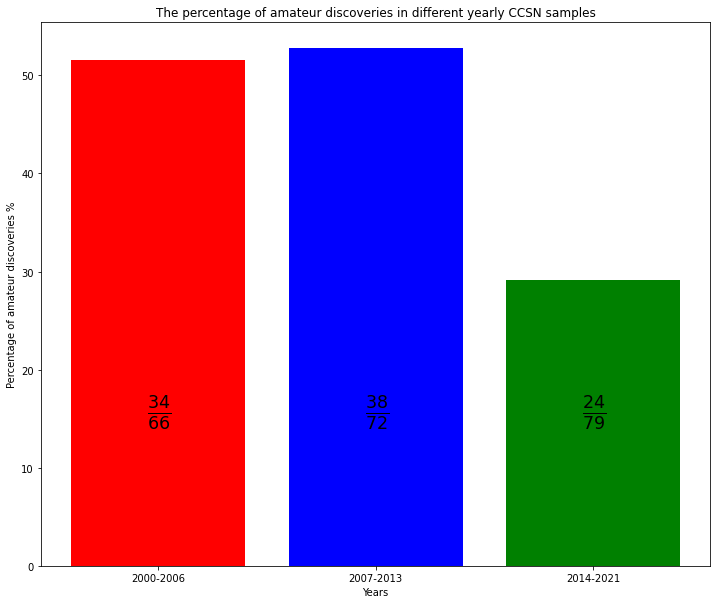

In [18]:
# This section is to plot the information about how the discovery method of CCSN has changed over the years

x = get_data_csv(data_path)
year_list1=[2000,2001,2002,2003,2004,2005,2006]
year_list2=[2007,2008,2009,2010,2011,2012,2013]
year_list3=[2014,2015,2016,2017,2018,2019,2020,2021]
x1 = x.loc[x['Year'].isin(year_list1)]
x2 = x.loc[x['Year'].isin(year_list2)]
x3 = x.loc[x['Year'].isin(year_list3)]
amateurs1=[]
amateurs2=[]
amateurs3=[]
for ama in x1['Amateur or no']:
    if ama != 'no':
        amateurs1.append(ama)
for ama in x2['Amateur or no']:
    if ama != 'no':
        amateurs2.append(ama)
for ama in x3['Amateur or no']:
    if ama != 'no':
        amateurs3.append(ama)
percent1 = len(amateurs1)/len(x1)
percent2 = len(amateurs2)/len(x2)
percent3 = (len(amateurs3)-1)/len(x3)
print(len(x3))
hist = [percent1*100, percent2*100, percent3*100]
plt.bar(height = hist,x =[1,2,3], color=['red','blue','green'])
#plt.errorbar(y=hist,x=[1,2,3], yerr=[[3,3,3],[3,3,3]], ecolor='black', capsize=10, linewidth = 0, elinewidth=2)
plt.xticks([1,2,3],['2000-2006','2007-2013','2014-2021'])
plt.xlabel('Years')
plt.text(0.95,15,'$\\frac{34}{66}$', size = 25)
plt.text(1.95,15,'$\\frac{38}{72}$', size = 25)
plt.text(2.95,15,'$\\frac{24}{79}$', size = 25)
plt.title('The percentage of amateur discoveries in different yearly CCSN samples')
plt.ylabel('Percentage of amateur discoveries %')

fig = plt.gcf()
fig.set_size_inches(12,10)
#plt.savefig('Percentages.jpg')

# Shell rate initialization

In [19]:
Cum_SNR_zero_to_thirty_a1 = pd.DataFrame(
    {'SNR': a1,
     'SNR upper limit': c1,
     'SNR lower limit': b1,
     'SNe': sum1
    })
Cum_SNR_zero_to_thirty_a2 = pd.DataFrame(
    {'SNR': a2,
     'SNR upper limit': c2,
     'SNR lower limit': b2,
     'SNe': sum2
    })
Cum_SNR_zero_to_thirty_a3 = pd.DataFrame(
    {'SNR': a3,
     'SNR upper limit': c3,
     'SNR lower limit': b3,
     'SNe': sum3
    })
Cum_SNR_zero_to_thirty_a4 = pd.DataFrame(
    {'SNR': np.round_(a4,2),
     'SNR upper limit': np.round_(c4,2),
     'SNR lower limit': np.round_(b4,2),
     'SNe': sum4
    })
############################################

Shell_SNR_zero_to_thirty_s1 = pd.DataFrame(
    {'SNR': s1,
     'SNR upper limit': s1_up,
     'SNR lower limit': s1_low,
     'SNe': shells1
    })
Shell_SNR_zero_to_thirty_s2 = pd.DataFrame(
    {'SNR': s2,
     'SNR upper limit': s2_up,
     'SNR lower limit': s2_low,
     'SNe': shells2
    })
Shell_SNR_zero_to_thirty_s3 = pd.DataFrame(
    {'SNR': s3,
     'SNR upper limit': s3_up,
     'SNR lower limit': s3_low,
     'SNe': shells3
    })
Shell_SNR_zero_to_thirty_s4 = pd.DataFrame(
    {'SNR': np.round_(s4,2),
     'SNR upper limit': np.round_(s4_up,2),
     'SNR lower limit': np.round_(s4_low,2),
     'SNe': shells4
    })


In [20]:
Cum_SNR_zero_to_thirty_a4_x = pd.DataFrame(
    {'SNR 5-30': np.round_(a4,2),
     'SNR upper limit 5-30': np.round(c4,2),
     'SNR lower limit 5-30': np.round(b4,2),
     'SNe 5-30': sum4
    })
Shell_SNR_zero_to_thirty_s4_x = pd.DataFrame(
    {'SNR 5-30': s4,
     'SNR upper limit 5-30': s4_up,
     'SNR lower limit 5-30': s4_low,
     'SNe 5-30': shells4
    })
SNR_kuvaaja_cum= pd.concat([Cum_SNR_zero_to_thirty_a4_x, Cum_SNR_zero_to_thirty_a4], axis=1)
SNR_kuvaaja_shell= Shell_SNR_zero_to_thirty_s4
SNR_kuvaaja_shell.to_csv('Shell kuvaaja',index=False)
SNR_kuvaaja_cum.to_csv('cum kuvaaja',index=False)


# Cumulative rates

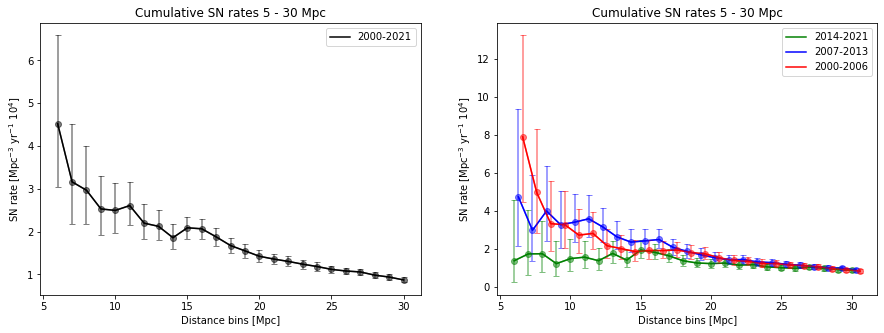

In [21]:
fig, ax =plt.subplots(ncols=2)
d=5#the starting distance for the plot
e=30
x=np.arange(1,31,1)
y=a3[d:e]
ax[1].errorbar(x[d:e], y, yerr=[b3[d:e],c3[d:e]], ecolor='g',marker='o',color='g',capsize=3,alpha=0.5)
ax[1].plot(x[d:e], y, color='g',label='2014-2021')
y=a2[d:e]
ax[1].errorbar(x[d:e]+0.3, y, yerr=[b2[d:e],c2[d:e]], ecolor='blue',marker='o',color='b',capsize=3,alpha=0.5)
ax[1].plot(x[d:e]+0.3, y, color='b',label='2007-2013')
y=a1[d:e]
ax[1].errorbar(x[d:e]+0.6, y, yerr=[b1[d:e],c1[d:e]], ecolor='red',marker='o',color='r',capsize=3,alpha=0.5)
ax[1].plot(x[d:e]+0.6, y, color='r',label='2000-2006')
ax[1].legend()

y=a4[d:e]
ax[0].plot(x[d:e], y, color='black', label='2000-2021')
ax[0].errorbar(x[d:e], y, yerr=[b4[d:e],c4[d:e]], ecolor='black',marker='o',color='black',capsize=3,alpha=0.5)
ax[0].legend()


ax[0].set_ylabel('SN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')
ax[1].set_ylabel('SN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')

ax[0].set_xlabel('Distance bins [Mpc]')
ax[1].set_xlabel('Distance bins [Mpc]')

ax[0].set_title('Cumulative SN rates 5 - 30 Mpc')
ax[1].set_title('Cumulative SN rates 5 - 30 Mpc')




fig = plt.gcf()
fig.set_size_inches(15,5)
#plt.savefig('Cumulative rates 5 - 30.jpg')

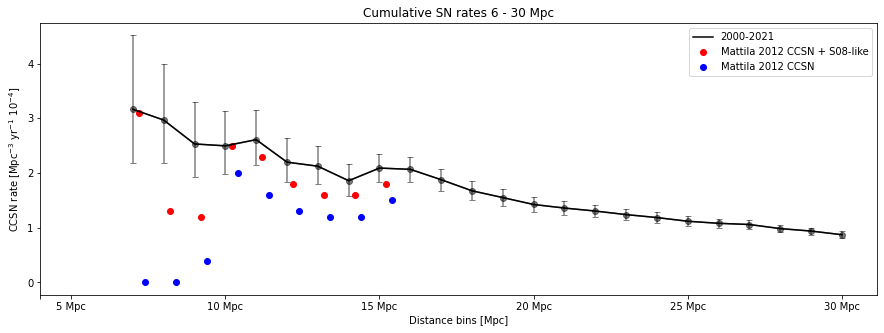

In [22]:
y=a4[6:e]
plt.plot(x[6:e], y, color='black', label='2000-2021')
plt.errorbar(x[6:e], y, yerr=[b4[6:e],c4[6:e]], ecolor='black',marker='o',color='black',capsize=3,alpha=0.5)
plt.ylabel('CCSN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^{-4}$]')
plt.xlabel('Distance bins [Mpc]')
plt.title('Cumulative SN rates 6 - 30 Mpc')


Mat_s= [3.1, 1.3, 1.2, 2.5, 2.3, 1.8, 1.6, 1.6, 1.8]
Mat_s_error_upper = []
Mat_s_error_lower = []
plt.scatter(x[6:15]+0.2, Mat_s, color='red', label='Mattila 2012 CCSN + S08-like')

Mat_CCSN = [0, 0, 0.39, 2, 1.6, 1.3, 1.2, 1.2, 1.5]
Mat_CCSN_error_upper = []
Mat_CCSN_error_lower = []
plt.scatter(x[6:15]+0.4, Mat_CCSN, color='blue', label='Mattila 2012 CCSN')

my_xticks = ['','5 Mpc','10 Mpc','15 Mpc','20 Mpc','25 Mpc','30 Mpc']
plt.xticks([4,5,10,15,20,25,30], my_xticks)

plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.savefig('Cumulative rates 6 - 30 comparison.jpg')

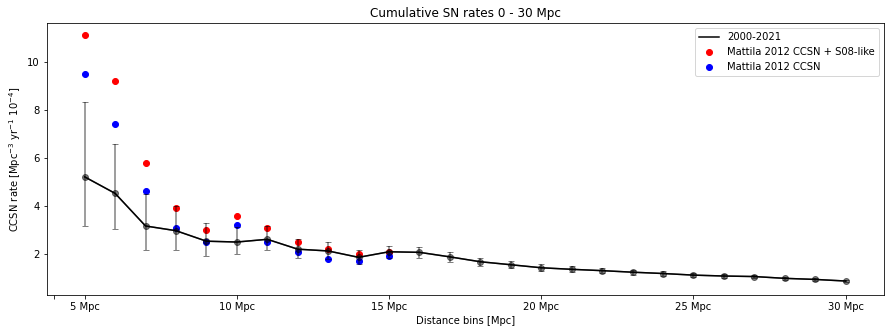

In [23]:
y=a4[4:e]
x=np.arange(1,31,1)

plt.plot(x[4:e], y, color='black', label='2000-2021')
plt.errorbar(x[4:e], y, yerr=[b4[4:e],c4[4:e]], ecolor='black',marker='o',color='black',capsize=3,alpha=0.5)
plt.ylabel('CCSN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^{-4}$]')
plt.xlabel('Distance bins [Mpc]')
plt.title('Cumulative SN rates 0 - 30 Mpc')


Mat_s= [11.1, 9.2, 5.8, 3.9, 3.0, 3.6, 3.1, 2.5, 2.2, 2.0, 2.1]
plt.scatter(x[4:15], Mat_s, color='red', label='Mattila 2012 CCSN + S08-like')

Mat_CCSN = [9.5, 7.4, 4.6, 3.1, 2.5, 3.2, 2.5, 2.1, 1.8, 1.7, 1.9]
plt.scatter(x[4:15], Mat_CCSN, color='blue', label='Mattila 2012 CCSN')

my_xticks = ['','5 Mpc','10 Mpc','15 Mpc','20 Mpc','25 Mpc','30 Mpc']
plt.xticks([4,5,10,15,20,25,30], my_xticks)

plt.legend()
fig = plt.gcf()
fig.set_size_inches(15,5)
#plt.savefig('Cumulative rates 0 - 30 comparison.jpg')

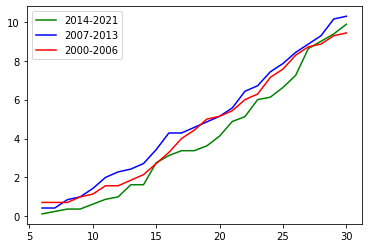

In [24]:
x=range(1,31,1)
y=sum3[d:e]/8
plt.plot(x[d:e], y, color='g', label='2014-2021')
y=sum2[d:e]/7
plt.plot(x[d:e], y, color='b', label='2007-2013')
y=sum1[d:e]/7
plt.plot(x[d:e], y, color='r', label='2000-2006')
plt.legend()


# Shell rates

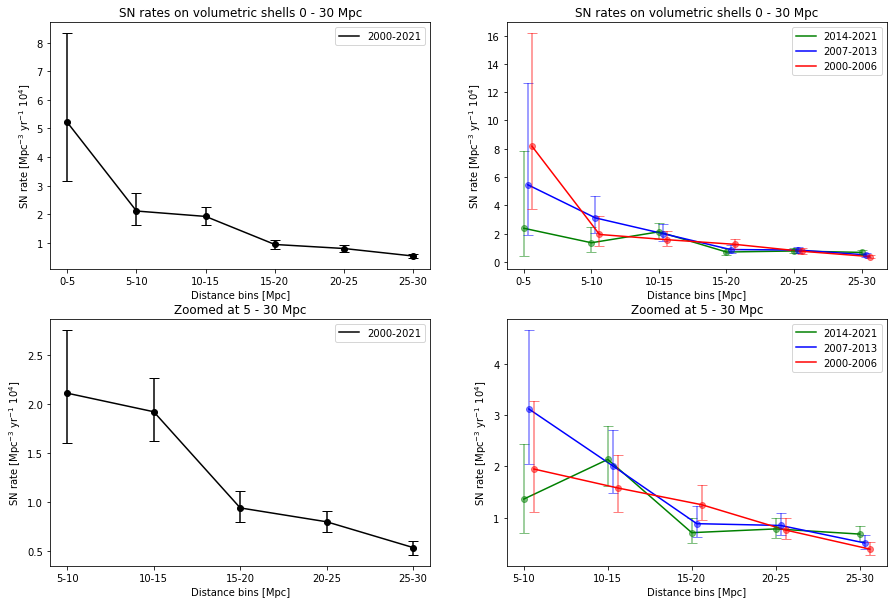

In [25]:
fig, ax =plt.subplots(ncols=2,nrows=2)
x=np.arange(0,30,5)
ax[0][1].errorbar(x, s3, yerr=[s3_low,s3_up], color='g', capsize=5, fmt='o', alpha=0.5)
ax[0][1].plot(x, s3, color='g', label='2014-2021')
ax[0][1].errorbar(x+0.3, s2, yerr=[s2_low,s2_up], color='b', capsize=5, fmt='o', alpha=0.5)
ax[0][1].plot(x+0.3, s2, color='b', label='2007-2013')
ax[0][1].errorbar(x+0.6, s1, yerr=[s1_low,s1_up], color='r', capsize=5, fmt='o', alpha=0.5)
ax[0][1].plot(x+0.6, s1, color='r', label='2000-2006')
my_xticks = ['0-5','5-10','10-15','15-20','20-25','25-30']
ax[0][1].set_xticks(x, my_xticks)
ax[0][1].legend()


ax[0][0].plot(x, s4, color='black', label='2000-2021')
ax[0][0].errorbar(x, s4, yerr=[s4_low,s4_up], color='black', capsize=5, fmt='o')
ax[0][0].set_xticks(x, my_xticks)
ax[0][0].legend()

ax[1][1].errorbar(x[1:], s3[1:], yerr=[s3_low[1:],s3_up[1:]], color='g', capsize=5, fmt='o', alpha=0.5)
ax[1][1].plot(x[1:], s3[1:], color='g', label='2014-2021')
ax[1][1].errorbar(x[1:]+0.3, s2[1:], yerr=[s2_low[1:],s2_up[1:]], color='b', capsize=5, fmt='o', alpha=0.5)
ax[1][1].plot(x[1:]+0.3, s2[1:], color='b', label='2007-2013')
ax[1][1].errorbar(x[1:]+0.6, s1[1:], yerr=[s1_low[1:],s1_up[1:]], color='r', capsize=5, fmt='o', alpha=0.5)
ax[1][1].plot(x[1:]+0.6, s1[1:], color='r', label='2000-2006')
my_xticks = ['0-5','5-10','10-15','15-20','20-25','25-30']
ax[1][1].set_xticks(x[1:], my_xticks[1:])
ax[1][1].legend()


ax[1][0].plot(x[1:], s4[1:], color='black', label='2000-2021')
ax[1][0].errorbar(x[1:], s4[1:], yerr=[s4_low[1:],s4_up[1:]], color='black', capsize=5, fmt='o')
ax[1][0].set_xticks(x[1:], my_xticks[1:])
ax[1][0].legend()

ax[0][0].set_ylabel('SN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')
ax[1][0].set_ylabel('SN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')
ax[1][1].set_ylabel('SN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')
ax[0][1].set_ylabel('SN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')

ax[0][0].set_xlabel('Distance bins [Mpc]')
ax[1][0].set_xlabel('Distance bins [Mpc]')
ax[1][1].set_xlabel('Distance bins [Mpc]')
ax[0][1].set_xlabel('Distance bins [Mpc]')

ax[0][0].set_title('SN rates on volumetric shells 0 - 30 Mpc')
ax[0][1].set_title('SN rates on volumetric shells 0 - 30 Mpc')
ax[1][1].set_title('Zoomed at 5 - 30 Mpc')
ax[1][0].set_title('Zoomed at 5 - 30 Mpc')



fig = plt.gcf()
fig.set_size_inches(15,10)
#plt.savefig('shell rates with errors.jpg')

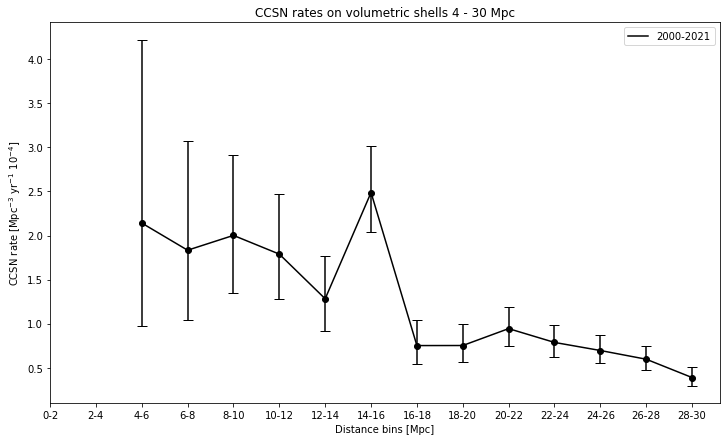

In [30]:
list4
x=np.arange(0,30,2)

shellz4=[sum(list4[0:2]),sum(list4[2:4]),sum(list4[4:6]),sum(list4[6:8]),sum(list4[8:10]),sum(list4[10:12]),sum(list4[12:14]),sum(list4[14:16]),sum(list4[16:18]),sum(list4[18:20]),sum(list4[20:22]),sum(list4[22:24]),sum(list4[24:26]),sum(list4[26:28]),sum(list4[28:30])]
a4,b4,c4,s4,s4_low,s4_up = calculate_snr(sum4, shellz4, 22, 1, upper, lower, 0)
plt.plot(x[2:], s4[2:], color='black', label='2000-2021')
plt.errorbar(x[2:], s4[2:], yerr=[s4_low[2:],s4_up[2:]], color='black', capsize=5, fmt='o')
my_xticks = ['0-2','2-4','4-6','6-8','8-10','10-12','12-14','14-16','16-18','18-20','20-22','22-24','24-26','26-28','28-30']
plt.xticks(x, my_xticks)
plt.ylabel('CCSN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^{-4}$]')
plt.xlabel('Distance bins [Mpc]')
plt.title('CCSN rates on volumetric shells 4 - 30 Mpc')


plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,7)
plt.savefig('shells by 2 Mpc.jpg',bbox_inches="tight")

# Statistical calculations
### Bootstrapping for significant decrease cumulatives

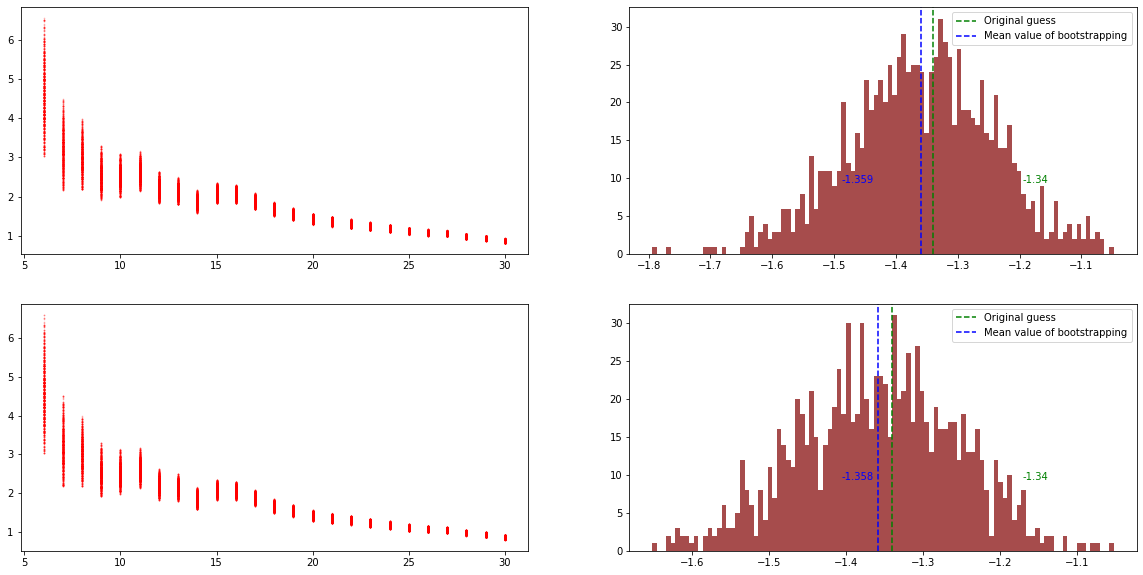

In [31]:
import random
import statistics


z1=s1[1:]
z2=s2[1:]
z3=s3[1:]
z4=s4[1:]

k4=a4
k_up4=c4
k_lo4=b4

l=0
o=0
start_distance = 15
end_distance = 17
fig, ax = plt.subplots(nrows=((end_distance)-start_distance),ncols=2)
for j in range((end_distance)-start_distance):  
    e=start_distance+j
    d=5
    original_mean_subtraction=(statistics.mean(k4[e:])-statistics.mean(k4[d:e]))    
    x=0
    mean_subtractions=[]
    while x <1000:
        value_list=[]
        for i in range(len(k4[d:])):
            a=i+1
            values = np.linspace(k4[d+i]-k_lo4[d+i],k4[d+i]+k_up4[d+i],100)
            mean = k4[d+i]
            probabilities = []
            for value in values:
                probability = 1 / (math.sqrt(2 * math.pi)) * math.exp(-0.5 * ((value - mean) / (((k4[d+i]+k_up4[d+i])-(k4[d+i]-k_lo4[d+i]))/4)) ** 2)
                probability = probability/len(values)
                probabilities.append(probability)
            g = float(random.choices(values,probabilities)[0])
            value_list.append(g)
        ax[l][0].scatter(range(d+1,31,1),value_list,color='r',alpha=0.2, s=0.75)
        #ax[o][1].plot(range(d+1,31,1),value_list,color='r',alpha=0.2)
        #print(value_list)
        mean_subtractions.append(statistics.mean(value_list[e-5:])-statistics.mean(value_list[d-5:e-5])) 
        x=x+1

    q=round(statistics.mean(mean_subtractions),3)
    qq=round(original_mean_subtraction,3)

    #x=range(1,31,1)
    #y=a4[d:]
    #ax[o][0].plot(x[d:], y, color='black',label='Combined',alpha=0.5)
    #ax[o][0].scatter(x[d:], y, s=7.5, color='black', alpha=0.5)
    #ax[o][0].errorbar(x[d:], y, yerr=[b4[d:],c4[d:]], ecolor='black',marker='',color='black',capsize=3,alpha=0.5)

    ax[l][1].axvline(x = original_mean_subtraction, color = 'g', linestyle='dashed', label='Original guess')
    ax[l][1].axvline(x = statistics.mean(mean_subtractions), color = 'b', linestyle='dashed', label='Mean value of bootstrapping')
    ax[l][1].legend()
    ax[l][1].text(0.45, 0.3, '%s'%q,color='b', horizontalalignment='center', verticalalignment='center', transform=ax[l][1].transAxes)
    ax[l][1].text(0.80, 0.3, '%s'%qq,color='g', horizontalalignment='center', verticalalignment='center', transform=ax[l][1].transAxes)
    ax[l][1].hist(mean_subtractions,bins=100,alpha=0.7,color='maroon')
    l=l+1
    o=o+1
fig = plt.gcf()
fig.set_size_inches(20,10)
#plt.savefig('bootstrap.jpg',bbox_inches="tight")

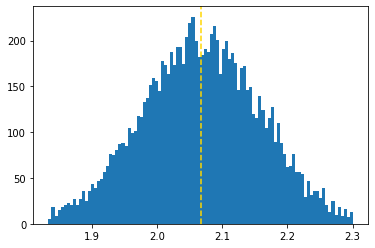

In [32]:
import random
import statistics
i=15
def linear_list(start, stop, n):
    return list(np.linspace(start, stop, n))

values = linear_list(a4[i]-b4[i],a4[i]+c4[i],100)
mean = statistics.mean(linear_list(a4[i]-b4[i],a4[i]+c4[i],100))
probabilities = []
for value in values:
    probability = 1 / (math.sqrt(2 * math.pi)) * math.exp(-0.5 * ((value - mean) / (((a4[i]+c4[i])-(a4[i]-b4[i]))/5)) ** 2)
    probability = probability/len(values)
    probabilities.append(probability)
#plt.plot(probabilities)
xx = []
x=0
while x<10000:
    xx.append(float(random.choices(values, weights=probabilities)[0]))
    x=x+1
plt.hist(xx,bins=100)
plt.axvline(x = mean, color = 'gold', linestyle='dashed', label='Mean value of bootstrapping')
#plt.plot(probabilities)
#random.choices(values,probabilities)

### Bootstrapping for significant decrease shells

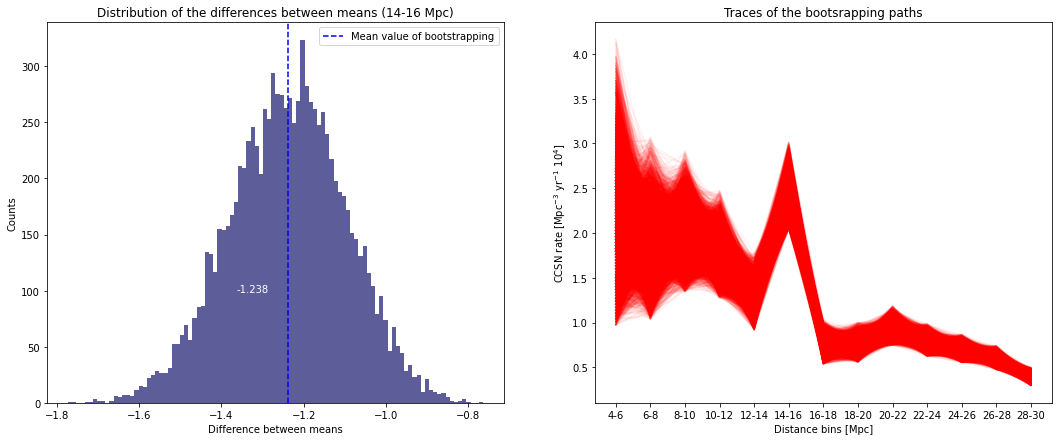

In [33]:
import random
import statistics

z1=s1[1:]
z2=s2[1:]
z3=s3[1:]
z4=s4[2:]
z_up4=s4_up[2:]
z_lo4=s4_low[2:]
my_xticks = ['0-2','2-4','4-6','6-8','8-10','10-12','12-14','14-16','16-18','18-20','20-22','22-24','24-26','26-28','28-30']
fig, ax = plt.subplots(nrows=1,ncols=2)
x=0
mean_subtractions=[]
while x <10000:
    value_list=[]
    for i in range(len(z4)):
        a=i+1
        values = np.linspace(z4[i]-z_lo4[i],z4[i]+z_up4[i],100)
        mean = z4[i]
        probabilities = []
        for value in values:
            probability = 1 / (math.sqrt(2 * math.pi)) * math.exp(-0.5 * ((value - mean) / (((z4[i]+z_up4[i])-(z4[i]-z_lo4[i]))/5)) ** 2)
            probability = probability/len(values)
            probabilities.append(probability)
        g = float(random.choices(values,probabilities)[0])
        value_list.append(g)
#    ax[0][0].scatter(range(5,30,5),value_list,color='r',alpha=0.2, s=0.75)
#    ax[0][0].set_xticks(range(5,30,5), my_xticks[1:])
    ax[1].plot(range(4,30,2),value_list,color='r',alpha=0.05)
    ax[1].set_xticks(range(4,30,2), my_xticks[2:])
    mean_subtractions.append(statistics.mean(value_list[6:])-statistics.mean(value_list[:6])) 
    x=x+1


q=round(statistics.mean(mean_subtractions),3)
qq=round(original_mean_subtraction,3)

#ax[1][0].plot(range(5,30,5), s4[1:], color='black', label='2000-2021')
#ax[1][0].errorbar(range(5,30,5), s4[1:], yerr=[s4_low[1:],s4_up[1:]], color='black', capsize=5, fmt='o')
#ax[1][0].set_xticks(range(5,30,5), my_xticks[1:])
#ax[1][0].legend()

#ax[1][1].axvline(x = original_mean_subtraction, color = 'g', linestyle='dashed', label='Original guess')
ax[0].axvline(x = statistics.mean(mean_subtractions), color = 'b', linestyle='dashed', label='Mean value of bootstrapping')
ax[0].set_xlabel('Difference between means')
ax[1].set_xlabel('Distance bins [Mpc]')
ax[1].set_ylabel('CCSN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')
ax[0].set_ylabel('Counts')
ax[1].set_title('Traces of the bootsrapping paths')
ax[0].set_title('Distribution of the differences between means (14-16 Mpc)')

ax[0].legend()
ax[0].text(0.45, 0.3, '%s'%q,color='white', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
#ax[0].text(0.45, 0.4, '%s'%qq,color='gold', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].hist(mean_subtractions,bins=100,alpha=0.7,color='midnightblue')

fig = plt.gcf()
fig.set_size_inches(18,7)
plt.savefig('bootstrap_shells (14-16 Mpc).jpg',bbox_inches="tight")

# Ks -test

In [34]:
import random
import scipy.stats as stats

upper1 = a1 + c1
upper2 = a2 + c2
upper3 = a3 + c3

lower1 = a1 - b1
lower2 = a2 - b2
lower3 = a3 - b3

d=5
e=14

stat, p = stats.ks_2samp(sum1[d:e]/7, sum3[d:e]/8)
print("statistic=%.5f, p-value=%.5f" % (stat, p))

statistic=0.55556, p-value=0.12587


In [35]:
means=[1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722,1.922426971564722]
z4[:7]

array([2.14173817, 1.83301915, 2.00129632, 1.78870441, 1.28167009,
       2.48813369, 0.75010185])

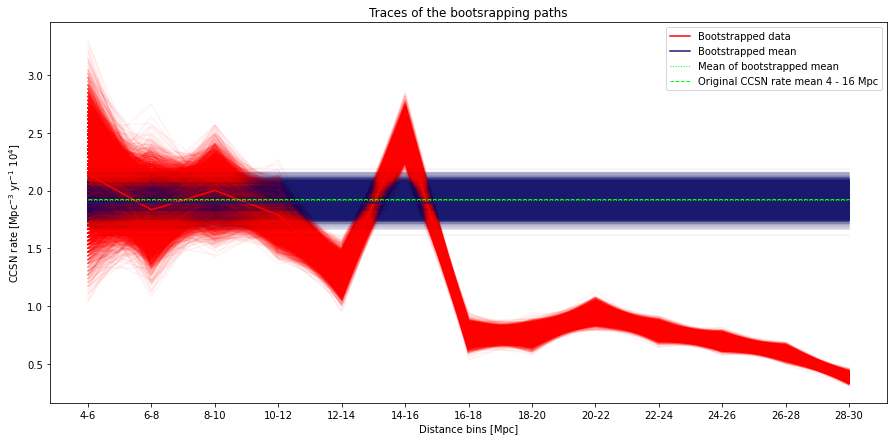

In [36]:
import random
import statistics
from scipy.stats import anderson_ksamp

xx=np.arange(0,30,2)
z4=s4[2:]
z_up4=s4_up[2:]
z_lo4=s4_low[2:]
my_xticks = ['0-2','2-4','4-6','6-8','8-10','10-12','12-14','14-16','16-18','18-20','20-22','22-24','24-26','26-28','28-30']

x=0
mean_an = []
mean_ks = []
meanofmeans=[]
while x <10000:
    value_list=[]
    for i in range(len(z4)):
        a=i+1
        values = np.linspace(z4[i]-z_lo4[i],z4[i]+z_up4[i],100)
        mean = z4[i]
        probabilities = []
        for value in values:
            probability = 1 / (math.sqrt(2 * math.pi)) * math.exp(-0.5 * ((value - mean) / (((z4[i]+z_up4[i])-(z4[i]-z_lo4[i]))/10)) ** 2)
            probability = probability/len(values)
            probabilities.append(probability)
        g = float(random.choices(values,probabilities)[0])
        value_list.append(g)
    men = statistics.mean(value_list[:6])
    means = [men, men, men, men, men, men, men, men, men, men, men, men, men]
    plt.plot(range(4,30,2),value_list,color='r',alpha=0.05)
    plt.plot(xx[2:],means, color='midnightblue', alpha=0.05)
    plt.xticks(range(4,30,2), my_xticks[2:])
    stat, p = stats.ks_2samp(value_list, means)
    statt, arr, pp = anderson_ksamp([value_list, means])
    mean_an.append(pp)
    mean_ks.append(p) 
    meanofmeans.append(men)
    x=x+1

q=statistics.mean(meanofmeans)
qq=statistics.mean(z4[:6])
plt.plot(range(4,30,2),z4,color='r',label='Bootstrapped data')
plt.plot(xx[2:],means, color='midnightblue',label='Bootstrapped mean')
plt.xlabel('Distance bins [Mpc]')
plt.ylabel('CCSN rate [Mpc$^{-3}$ yr$^{-1}$ 10$^4$]')
plt.title('Traces of the bootsrapping paths')
plt.axhline(q,0.045,0.955,label='Mean of bootstrapped mean', color='lime', linestyle='dotted', linewidth=1)
plt.axhline(qq,0.045,0.955,label='Original CCSN rate mean 4 - 16 Mpc', color='lime', linestyle='dashed', linewidth=1)


plt.legend()

fig = plt.gcf()
fig.set_size_inches(15,7)
plt.savefig('Bootstrap, KS, ADD.jpg',bbox_inches="tight")

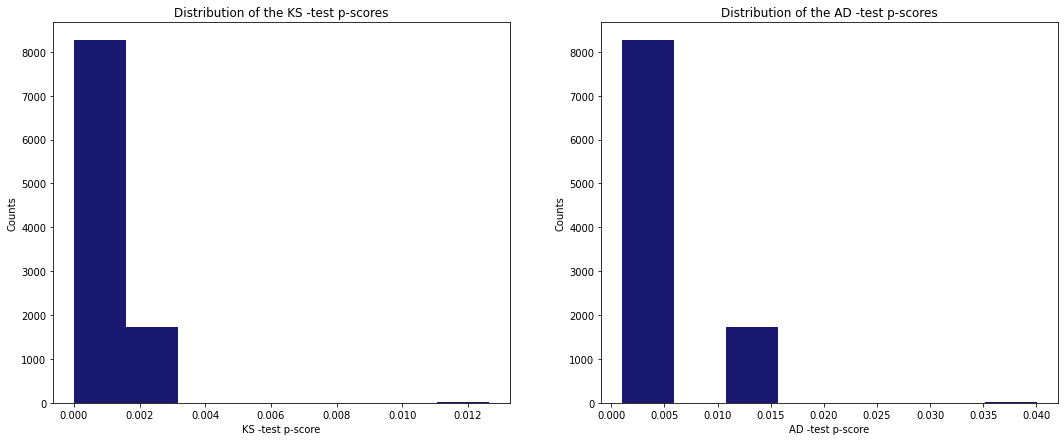

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=2)


ax[0].set_ylabel('Counts')
ax[0].set_title('Distribution of the KS -test p-scores')
ax[0].set_xlabel('KS -test p-score')
ax[0].hist(mean_ks,bins=8,color='midnightblue')
ax[1].set_xlabel('AD -test p-score')
ax[1].set_title('Distribution of the AD -test p-scores')
ax[1].set_ylabel('Counts')
ax[1].hist(mean_an,bins=8,color='midnightblue')

fig = plt.gcf()
fig.set_size_inches(18,7)
plt.savefig('Bootstrap, KS, AD distributions.jpg',bbox_inches="tight")